In [5]:
import numpy as np
import os
import time
from datetime import datetime

from src.data_preprocessing import load_data, create_binary_labels, preprocess_data
from src.logistic_regression import LogisticRegression, KernelLogisticRegression
from src.svm import SVM, KernelSVM
from src.kernels import create_kernel_function
from src.evaluation import (
    calculate_metrics, 
    print_metrics,
    plot_confusion_matrix,
    plot_training_curves,
    plot_all_metrics_comparison,
    cross_validate,
    analyze_misclassifications
)

if not os.path.exists('results'):
    os.makedirs('results')

## Load and Preprocess Data

In [6]:
wines = load_data('data/winequality-red.csv', 'data/winequality-white.csv')

# Converting to binary classification problem
wines = create_binary_labels(wines, threshold=6)

# Splitting and normalizing
X_train, X_test, y_train, y_test, mean, std = preprocess_data(
    wines, test_size=0.2, random_state=42, normalize=True
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Loaded 1599 red wines and 4898 white wines
Total dataset size: 6497 samples

Dataset shape: (6497, 13)

Binary label distribution:
Bad wines (quality < 6): 2384 (36.7%)
Good wines (quality >= 6): 4113 (63.3%)

Train set size: 5199 samples
Test set size: 1298 samples
Train label distribution: Bad=1908, Good=3291
Test label distribution: Bad=476, Good=822

Features normalized (standardization: mean=0, std=1)
Training set: (5199, 12)
Test set: (1298, 12)


## Standard Logistic Regression

Iteration 100/1000 - Loss: 0.5324, Accuracy: 0.7246
Iteration 200/1000 - Loss: 0.5210, Accuracy: 0.7334
Iteration 300/1000 - Loss: 0.5184, Accuracy: 0.7351
Iteration 400/1000 - Loss: 0.5176, Accuracy: 0.7359
Iteration 500/1000 - Loss: 0.5173, Accuracy: 0.7376
Iteration 600/1000 - Loss: 0.5172, Accuracy: 0.7386
Iteration 700/1000 - Loss: 0.5171, Accuracy: 0.7394
Iteration 800/1000 - Loss: 0.5171, Accuracy: 0.7394
Iteration 900/1000 - Loss: 0.5171, Accuracy: 0.7399
Iteration 1000/1000 - Loss: 0.5171, Accuracy: 0.7399
Final Loss: 0.5171
Final Accuracy: 0.7399

Training time: 0.15s

Logistic Regression - Performance Metrics
Accuracy:  0.7565 (75.65%)
Precision: 0.7824 (78.24%)
Recall:    0.8528 (85.28%)
F1-Score:  0.8161 (81.61%)

Confusion Matrix:
  True Positives:  701
  True Negatives:  281
  False Positives: 195
  False Negatives: 121



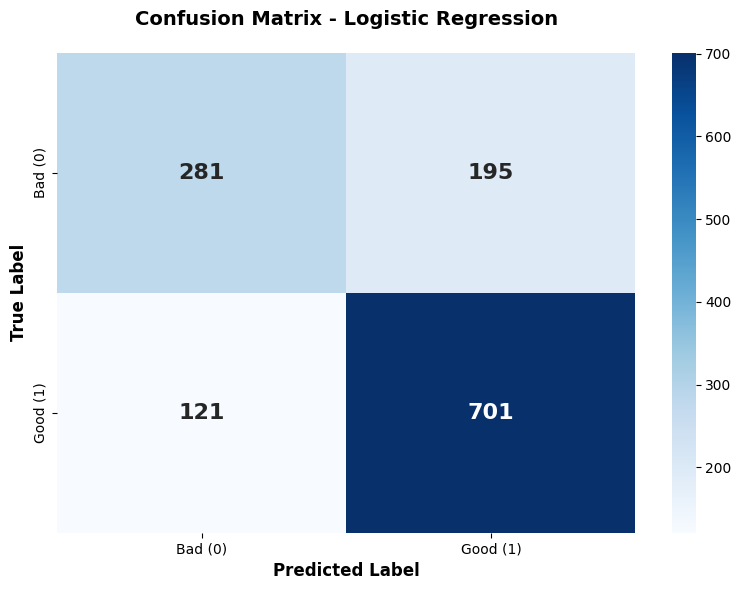

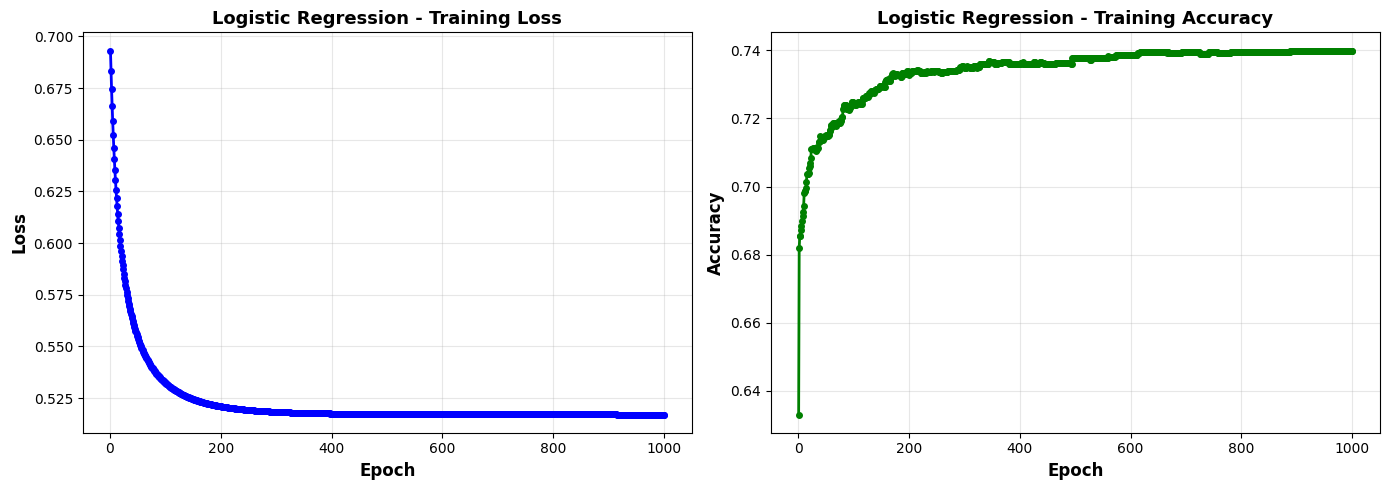

In [7]:
lr = LogisticRegression(
    learning_rate=0.1,
    n_iterations=1000,
    regularization=0.01,
    verbose=True
)

start = time.time()
lr.fit(X_train, y_train)
lr_time = time.time() - start

# Evaluating
y_pred_lr = lr.predict(X_test)
lr_metrics = calculate_metrics(y_test, y_pred_lr)

print(f"\nTraining time: {lr_time:.2f}s")
print_metrics(lr_metrics, "Logistic Regression")

# Plotting
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression", 
                     save_path='results/LR_confusion_matrix.png')
plot_training_curves(lr.history, "Logistic Regression",
                    save_path='results/LR_training_curves.png')

## Standard SVM

Iteration 100/1000 - Loss: 0.9633, Accuracy: 0.6824
Iteration 200/1000 - Loss: 0.9316, Accuracy: 0.6836
Iteration 300/1000 - Loss: 0.9043, Accuracy: 0.6815
Iteration 400/1000 - Loss: 0.8808, Accuracy: 0.6796
Iteration 500/1000 - Loss: 0.8602, Accuracy: 0.6807
Iteration 600/1000 - Loss: 0.8424, Accuracy: 0.6782
Iteration 700/1000 - Loss: 0.8278, Accuracy: 0.6807
Iteration 800/1000 - Loss: 0.8166, Accuracy: 0.6836
Iteration 900/1000 - Loss: 0.8086, Accuracy: 0.6815
Iteration 1000/1000 - Loss: 0.8025, Accuracy: 0.6807
Final Loss: 0.8025
Final Accuracy: 0.6807

Training time: 5.24s

SVM - Performance Metrics
Accuracy:  0.6934 (69.34%)
Precision: 0.7404 (74.04%)
Recall:    0.7944 (79.44%)
F1-Score:  0.7664 (76.64%)

Confusion Matrix:
  True Positives:  653
  True Negatives:  247
  False Positives: 229
  False Negatives: 169



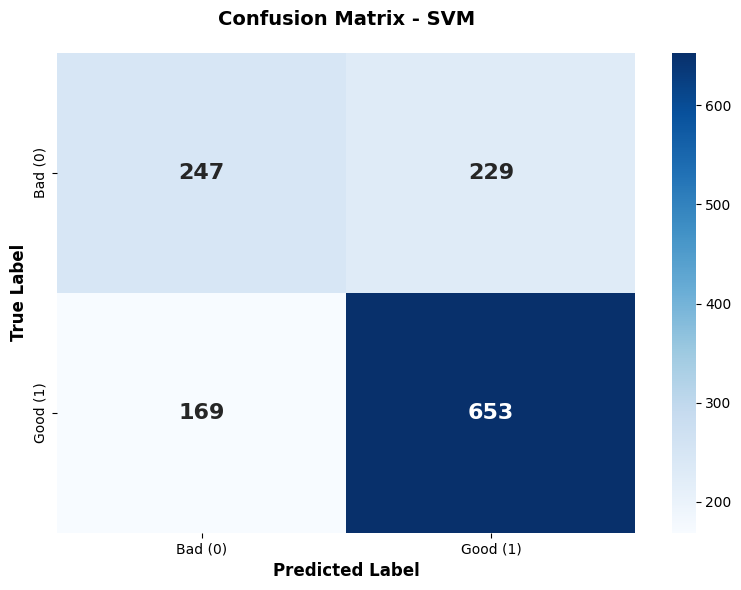

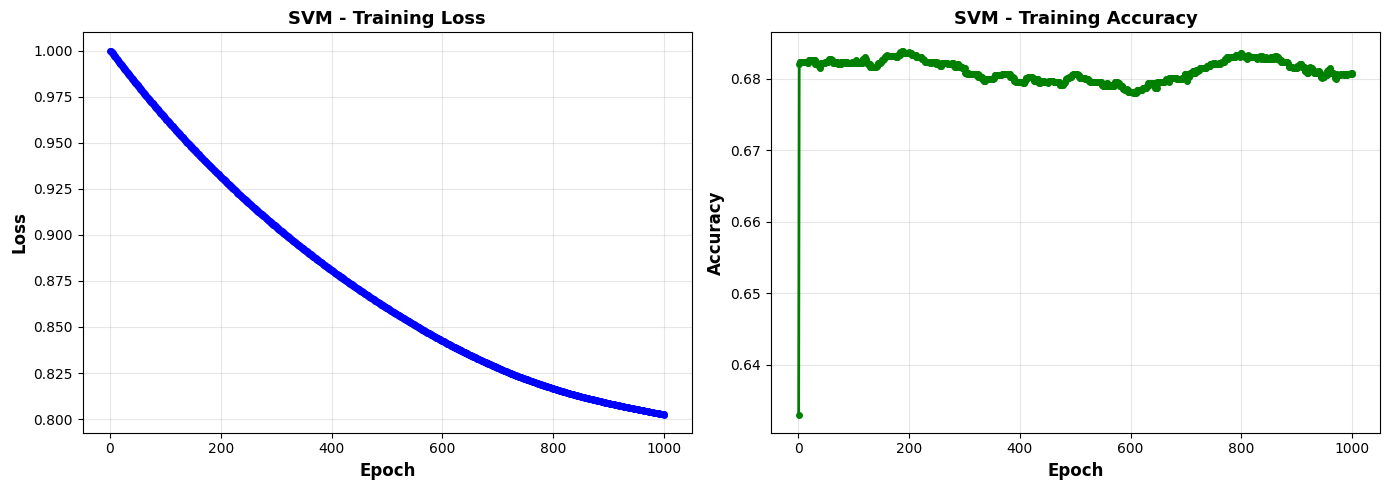

In [8]:
svm = SVM(
    learning_rate=0.001,
    n_iterations=1000,
    C=1.0,
    verbose=True
)

start = time.time()
svm.fit(X_train, y_train)
svm_time = time.time() - start

# Evaluating
y_pred_svm = svm.predict(X_test)
svm_metrics = calculate_metrics(y_test, y_pred_svm)

print(f"\nTraining time: {svm_time:.2f}s")
print_metrics(svm_metrics, "SVM")

# Plotting
plot_confusion_matrix(y_test, y_pred_svm, "SVM",
                     save_path='results/SVM_confusion_matrix.png')
plot_training_curves(svm.history, "SVM",
                    save_path='results/SVM_training_curves.png')

## Kernelized Logistic Regression - Polynomial

Training with Polynomial (d=2)...
  Time: 4.28s | Accuracy: 0.6387 | F1: 0.6539



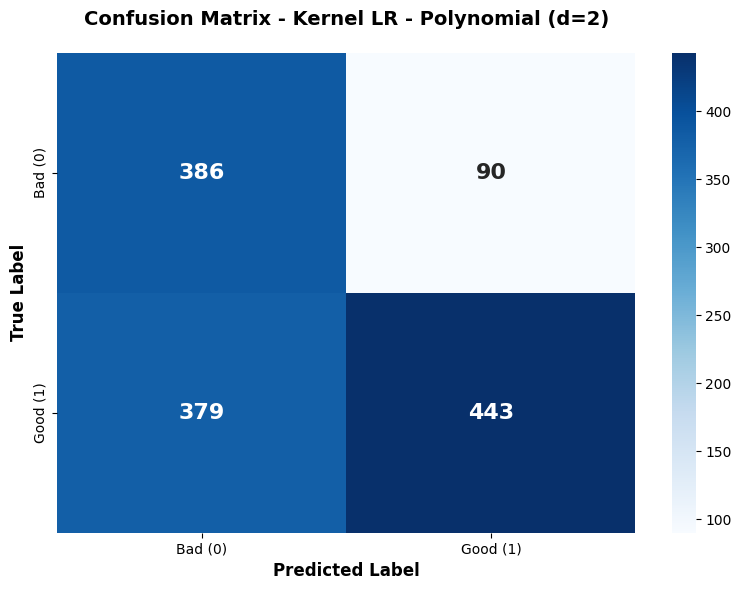

Training with Polynomial (d=3)...
  Time: 4.33s | Accuracy: 0.6579 | F1: 0.7296



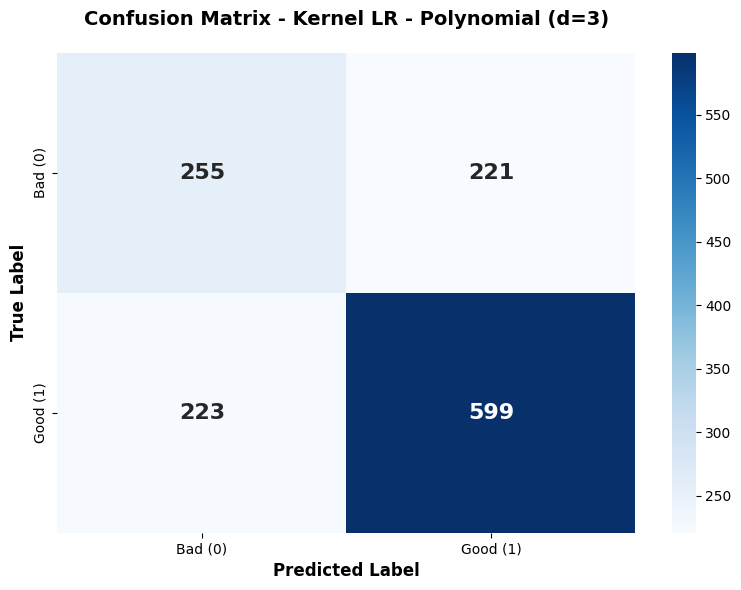

In [9]:
kernels_lr_poly = {
    'Polynomial (d=2)': create_kernel_function('polynomial', degree=2, coef0=1.0),
    'Polynomial (d=3)': create_kernel_function('polynomial', degree=3, coef0=1.0),
}

results_lr_poly = {}

for name, kernel_func in kernels_lr_poly.items():
    print(f"Training with {name}...")
    
    klr = KernelLogisticRegression(
        kernel_func=kernel_func,
        learning_rate=0.01,
        n_iterations=500,
        regularization=0.1,
        verbose=False
    )
    
    start = time.time()
    klr.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = klr.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    results_lr_poly[name] = metrics
    
    print(f"  Time: {train_time:.2f}s | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_score']:.4f}\n")
    
    # Saving plots
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '')
    plot_confusion_matrix(y_test, y_pred, f"Kernel LR - {name}",
                         save_path=f'results/KLR_{safe_name}_confusion.png')


## Kernelized Logistic Regression - RBF

Training with RBF (γ=0.1)...
  Time: 4.63s | Accuracy: 0.7619 | F1: 0.8231



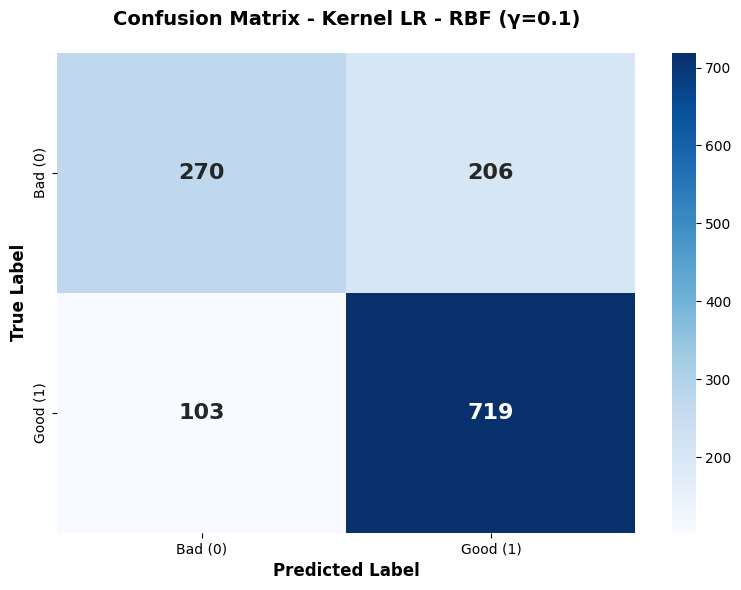

Training with RBF (γ=0.5)...
  Time: 4.43s | Accuracy: 0.7419 | F1: 0.8146



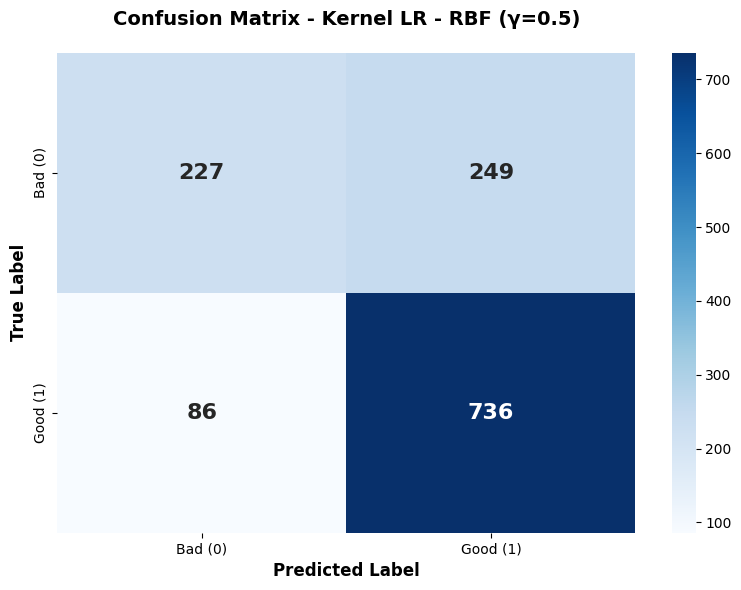

In [10]:
kernels_lr_rbf = {
    'RBF (γ=0.1)': create_kernel_function('rbf', gamma=0.1),
    'RBF (γ=0.5)': create_kernel_function('rbf', gamma=0.5),
}

results_lr_rbf = {}

for name, kernel_func in kernels_lr_rbf.items():
    print(f"Training with {name}...")
    
    klr = KernelLogisticRegression(
        kernel_func=kernel_func,
        learning_rate=0.01,
        n_iterations=500,
        regularization=0.1,
        verbose=False
    )
    
    start = time.time()
    klr.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = klr.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    results_lr_rbf[name] = metrics
    
    print(f"  Time: {train_time:.2f}s | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_score']:.4f}\n")
    
    # Saving plots
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
    plot_confusion_matrix(y_test, y_pred, f"Kernel LR - {name}",
                         save_path=f'results/KLR_{safe_name}_confusion.png')

## Kernelized SVM - Polynomial

Training with Polynomial (d=2)...
  Time: 33.63s | Accuracy: 0.5747 | F1: 0.5591



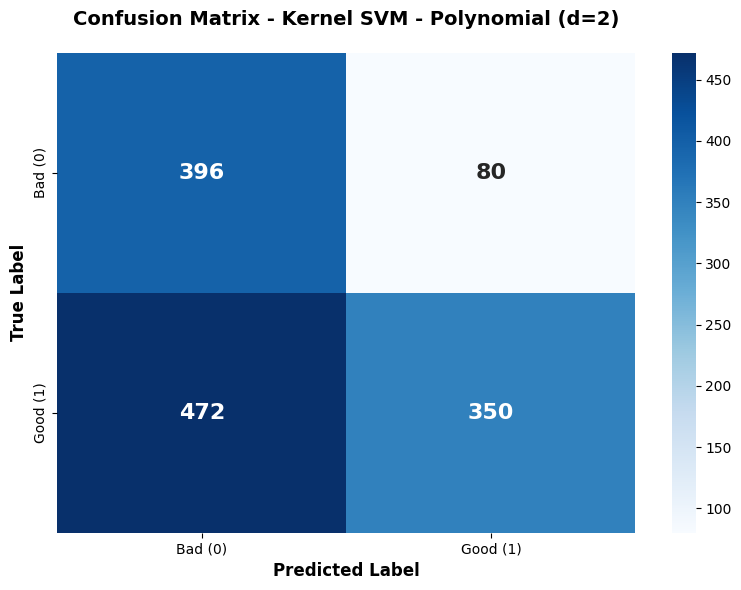

Training with Polynomial (d=3)...
  Time: 144.92s | Accuracy: 0.6880 | F1: 0.7547



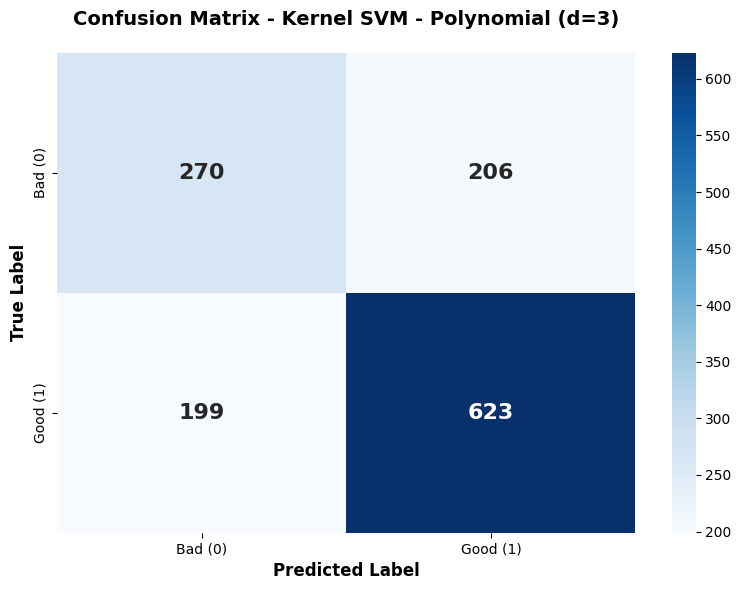

In [11]:
kernels_svm_poly = {
    'Polynomial (d=2)': create_kernel_function('polynomial', degree=2, coef0=1.0),
    'Polynomial (d=3)': create_kernel_function('polynomial', degree=3, coef0=1.0),
}

results_svm_poly = {}

for name, kernel_func in kernels_svm_poly.items():
    print(f"Training with {name}...")
    
    ksvm = KernelSVM(
        kernel_func=kernel_func,
        learning_rate=0.001,
        n_iterations=500,
        C=1.0,
        verbose=False
    )
    
    start = time.time()
    ksvm.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = ksvm.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    results_svm_poly[name] = metrics
    
    print(f"  Time: {train_time:.2f}s | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_score']:.4f}\n")
    
    # Saving plots
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '')
    plot_confusion_matrix(y_test, y_pred, f"Kernel SVM - {name}",
                         save_path=f'results/KSVM_{safe_name}_confusion.png')


## Kernelized SVM - RBF

Training with RBF (γ=0.1)...
  Time: 87.07s | Accuracy: 0.6803 | F1: 0.7822



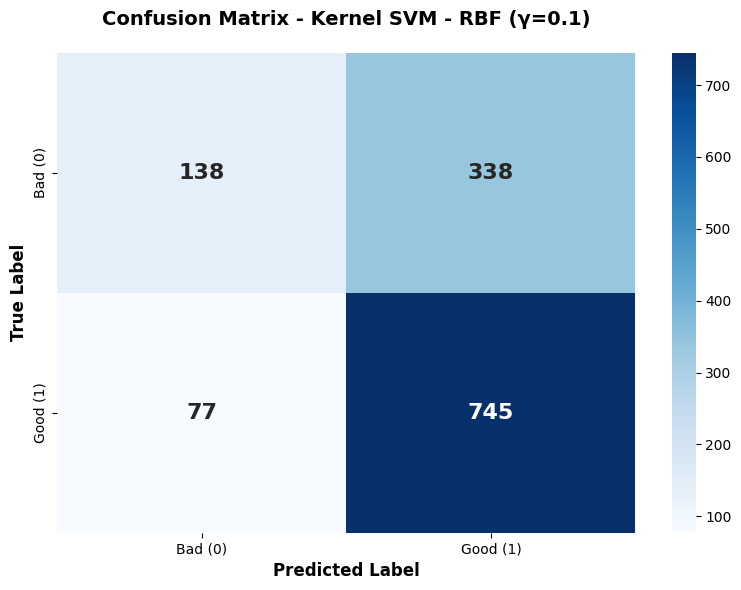

Training with RBF (γ=0.5)...
  Time: 97.15s | Accuracy: 0.6880 | F1: 0.7903



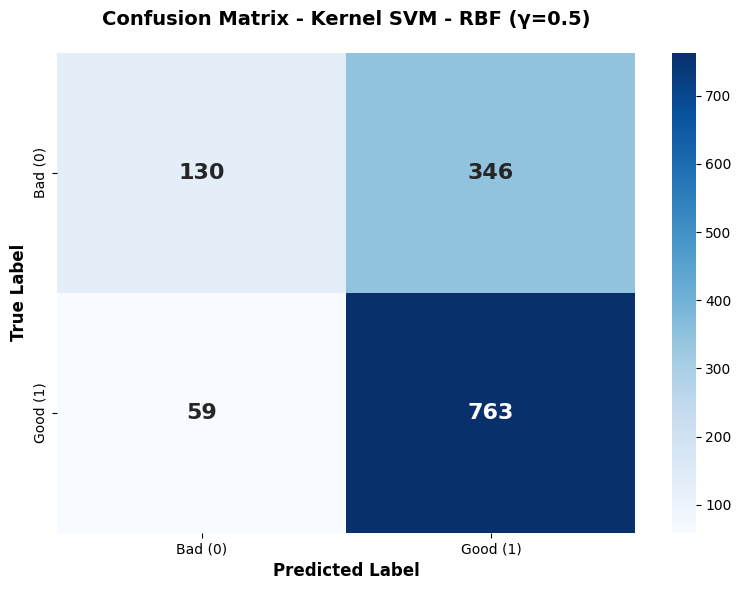

In [12]:
kernels_svm_rbf = {
    'RBF (γ=0.1)': create_kernel_function('rbf', gamma=0.1),
    'RBF (γ=0.5)': create_kernel_function('rbf', gamma=0.5),
}

results_svm_rbf = {}

for name, kernel_func in kernels_svm_rbf.items():
    print(f"Training with {name}...")
    
    ksvm = KernelSVM(
        kernel_func=kernel_func,
        learning_rate=0.001,
        n_iterations=500,
        C=1.0,
        verbose=False
    )
    
    start = time.time()
    ksvm.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = ksvm.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    results_svm_rbf[name] = metrics
    
    print(f"  Time: {train_time:.2f}s | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_score']:.4f}\n")
    
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
    plot_confusion_matrix(y_test, y_pred, f"Kernel SVM - {name}",
                         save_path=f'results/KSVM_{safe_name}_confusion.png')


## Hyperparameter Tuning with Cross-Validation

In [13]:
regularization_values = [0.001, 0.01, 0.1, 1.0]
cv_results = {}
best_cv_score = 0
best_reg = None

for reg in regularization_values:
    print(f"Testing regularization = {reg}")
    
    lr_cv = LogisticRegression(
        learning_rate=0.1,
        n_iterations=1000,
        regularization=reg,
        verbose=False
    )
    
    cv_result = cross_validate(lr_cv, X_train, y_train, k=5, random_state=42)
    cv_results[f'λ={reg}'] = cv_result['avg_metrics']
    
    if cv_result['avg_metrics']['accuracy'] > best_cv_score:
        best_cv_score = cv_result['avg_metrics']['accuracy']
        best_reg = reg

print(f"\nBest regularization: {best_reg} (CV Accuracy: {best_cv_score:.4f})")

# Training final model with best parameter
lr_best = LogisticRegression(
    learning_rate=0.1,
    n_iterations=1000,
    regularization=best_reg,
    verbose=False
)

lr_best.fit(X_train, y_train)
y_pred_best = lr_best.predict(X_test)
lr_best_metrics = calculate_metrics(y_test, y_pred_best)

print_metrics(lr_best_metrics, f"LR (Best: λ={best_reg})")


Testing regularization = 0.001

Performing 5-Fold Cross-Validation...

Fold 1/5
----------------------------------------
Training samples: 4158, Validation samples: 1041
Accuracy: 0.7550, F1-Score: 0.8135

Fold 2/5
----------------------------------------
Training samples: 4159, Validation samples: 1040
Accuracy: 0.7154, F1-Score: 0.7855

Fold 3/5
----------------------------------------
Training samples: 4159, Validation samples: 1040
Accuracy: 0.7500, F1-Score: 0.8140

Fold 4/5
----------------------------------------
Training samples: 4160, Validation samples: 1039
Accuracy: 0.7392, F1-Score: 0.8052

Fold 5/5
----------------------------------------
Training samples: 4160, Validation samples: 1039
Accuracy: 0.7305, F1-Score: 0.7950

Cross-Validation Results
Average Accuracy:  0.7380 ± 0.0142
Average Precision: 0.7672 ± 0.0111
Average Recall:    0.8417 ± 0.0156
Average F1-Score:  0.8026 ± 0.0110

Testing regularization = 0.01

Performing 5-Fold Cross-Validation...

Fold 1/5
---------

# Comparing All Models


Model Comparison - Test Set Performance:
Model                                    Accuracy     F1-Score    
----------------------------------------------------------------------
Logistic Regression                      0.7565       0.8161      
SVM                                      0.6934       0.7664      
LR - Polynomial (d=2)                    0.6387       0.6539      
LR - Polynomial (d=3)                    0.6579       0.7296      
LR - RBF (γ=0.1)                         0.7619       0.8231      
LR - RBF (γ=0.5)                         0.7419       0.8146      
SVM - Polynomial (d=2)                   0.5747       0.5591      
SVM - Polynomial (d=3)                   0.6880       0.7547      
SVM - RBF (γ=0.1)                        0.6803       0.7822      
SVM - RBF (γ=0.5)                        0.6880       0.7903      
LR (Best: λ=1.0)                         0.7558       0.8156      


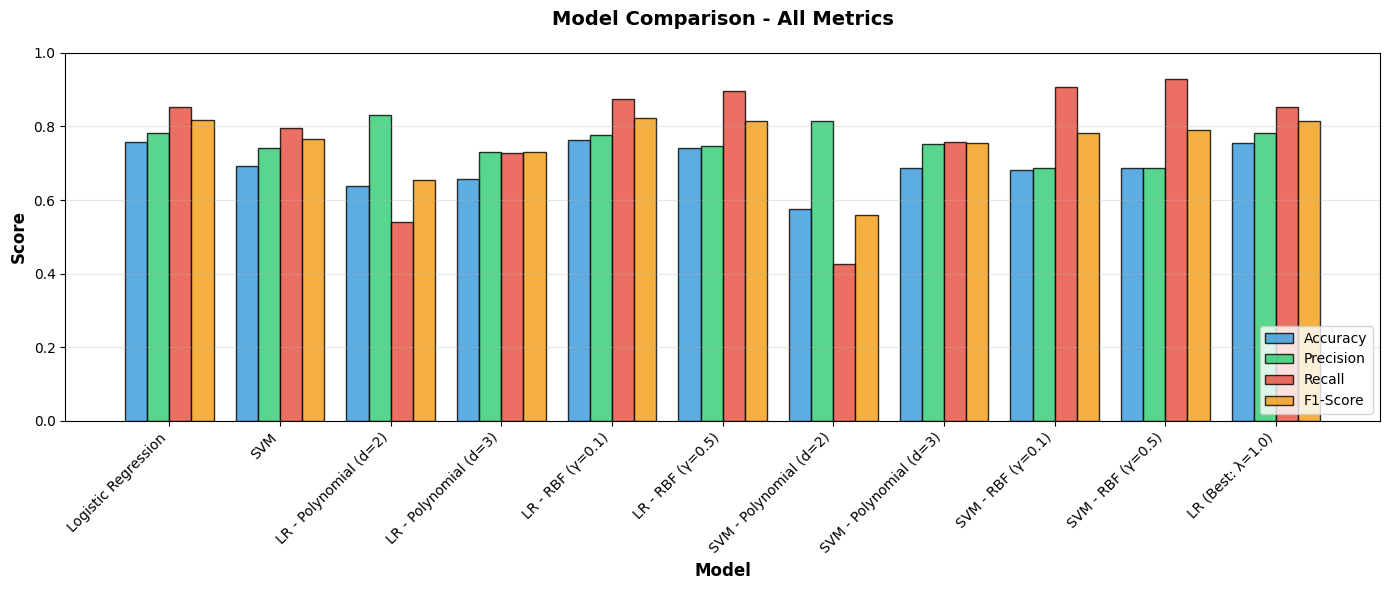


Best Model: LR - RBF (γ=0.1)
F1-Score: 0.8231
Accuracy: 0.7619


In [14]:
all_results = {
    'Logistic Regression': lr_metrics,
    'SVM': svm_metrics,
    **{f'LR - {k}': v for k, v in results_lr_poly.items()},
    **{f'LR - {k}': v for k, v in results_lr_rbf.items()},
    **{f'SVM - {k}': v for k, v in results_svm_poly.items()},
    **{f'SVM - {k}': v for k, v in results_svm_rbf.items()},
    f'LR (Best: λ={best_reg})': lr_best_metrics
}

print("\nModel Comparison - Test Set Performance:")
print("="*70)
print(f"{'Model':<40} {'Accuracy':<12} {'F1-Score':<12}")
print("-"*70)

for name, metrics in all_results.items():
    print(f"{name:<40} {metrics['accuracy']:<12.4f} {metrics['f1_score']:<12.4f}")

plot_all_metrics_comparison(all_results, save_path='results/model_comparison.png')

# Finding best model
best_model = max(all_results.items(), key=lambda x: x[1]['f1_score'])
print(f"\nBest Model: {best_model[0]}")
print(f"F1-Score: {best_model[1]['f1_score']:.4f}")
print(f"Accuracy: {best_model[1]['accuracy']:.4f}")

## Misclassification Analysis

In [15]:
# Analyzing misclassifications from best model: LR - RBF (γ=0.1)

# Training the best model again to get predictions
best_kernel = create_kernel_function('rbf', gamma=0.1)
best_model = KernelLogisticRegression(
    kernel_func=best_kernel,
    learning_rate=0.01,
    n_iterations=500,
    regularization=0.1,
    verbose=False
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Getting metrics for verification
best_metrics = calculate_metrics(y_test, y_pred_best)
print(f"\nVerified metrics:")
print(f"  Accuracy: {best_metrics['accuracy']:.4f}")
print(f"  F1-Score: {best_metrics['f1_score']:.4f}")

# Analyzing misclassifications
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 
                'residual sugar', 'chlorides', 'free sulfur dioxide',
                'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                'alcohol', 'wine_type']

analyze_misclassifications(X_test, y_test, y_pred_best, 
                          feature_names=feature_names, n_samples=5)



Verified metrics:
  Accuracy: 0.7619
  F1-Score: 0.8231

Misclassification Analysis
Total samples: 1298
Misclassified: 309 (23.81%)

False Positives (predicted Good, actually Bad): 206
False Negatives (predicted Bad, actually Good): 103

Sample Misclassified Examples (showing up to 5):

Sample 1 (Index: 5):
  True Label: 0 (Bad)
  Predicted:  1 (Good)
  Features:
    fixed acidity: -0.092
    volatile acidity: 0.558
    citric acid: 0.698
    residual sugar: 0.014
    chlorides: 0.428
    free sulfur dioxide: -0.145
    total sulfur dioxide: 0.210
    density: 0.870
    pH: 1.270
    sulphates: 1.230
    alcohol: 0.008
    wine_type: -1.772

Sample 2 (Index: 13):
  True Label: 0 (Bad)
  Predicted:  1 (Good)
  Features:
    fixed acidity: -1.018
    volatile acidity: -0.724
    citric acid: 0.905
    residual sugar: 3.596
    chlorides: 1.831
    free sulfur dioxide: 1.386
    total sulfur dioxide: 0.104
    density: 0.558
    pH: -0.734
    sulphates: -1.228
    alcohol: 1.931
    win